In [216]:
from Bio import pairwise2,Phylo
from Bio.Cluster import treecluster,kcluster
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import linkage,dendrogram
import matplotlib.pyplot as plt
import os
#Reading Alzheimers and Cancer siRNA sequence
alist=[]
file_loc = "ASPsiDB.xlsx"
df1 = pd.read_excel(file_loc, 'Alzheimers',index_col=None, na_values=['NA'], usecols = "C,G,H")
df2 = pd.read_excel(file_loc, 'Cancer',index_col=None, na_values=['NA'], usecols = "C,G,H")
df3 = pd.read_excel(file_loc, 'ALS',index_col=None, na_values=['NA'], usecols = "C,G,H")

#Data: siRNA,Disease
alz= df1.iloc[::2, :]
can = df2.iloc[::2, :]
als = df3.iloc[::2, :]

frames = [alz,can,als]

#Final dataset with all siRNA and corresponding disease
dataset = pd.concat(frames)


In [217]:
X1=[]
X2=[]
X3=[]
target=[]
disease = {
"Alzheimers disease" : 0,
"Cancer" : 1,
"Amyotrophic Lateral Sclerosis (ALS)" : 2,
}
dataset.Disease=dataset['Disease'].map(disease)
dataset.Disease
dataset.head()

for index, row in dataset.iterrows():
    X1.append(row['ASP-siRNA'])
    X2.append(row['Disease'])
    X3.append(row['Gene'])
    


In [218]:
print(len(X1))
sizes = [len(rec) for rec in X1]
print(len(sizes))


473
473


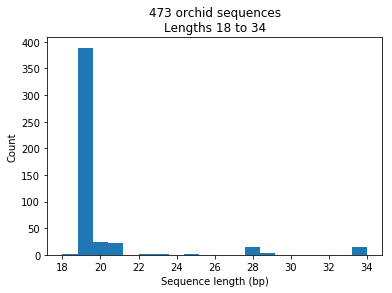

In [219]:
import pylab
pylab.hist(sizes, bins=20)
pylab.title("%i orchid sequences\nLengths %i to %i" \
            % (len(sizes),min(sizes),max(sizes)))
pylab.xlabel("Sequence length (bp)")
pylab.ylabel("Count")
pylab.show()

In [220]:
X=[]
for rec in X1:
    if(len(rec)==19):
        X.append(rec)
        
print(len(X))


389


In [221]:
pre_dataset=dataset.loc[dataset['ASP-siRNA'].isin(X)]
pre_dataset.head()
X1=[]
X2=[]
X3=[]
target=[]

for index, row in pre_dataset.iterrows():
    X1.append(row['ASP-siRNA'])
    X2.append(row['Disease'])
    X3.append(row['Gene'])
    
    

In [222]:
x=[]
y=[]
x1=[]
x2=[]


for i, ele_1 in enumerate(X1):   #sirna pairs and alignments
    for j, ele_2 in enumerate(X1):
        if j >= i:
            break
        x.append(ele_1+'\r\n'+ele_2)
        alignment_score=pairwise2.align.globalxx(ele_1,ele_2,score_only=True)
        x1.append(alignment_score) 
        
for i, ele_1 in enumerate(X3):   
    for j, ele_2 in enumerate(X3):
        if j >= i:
            break
        
        if(ele_1==ele_2):    #Gene type same or not
            x2.append(0)
        else:
            x2.append(1)
        
        
for i, ele_1 in enumerate(X2):   #Disease
    for j, ele_2 in enumerate(X2):
        if j >= i:
            break
        a=str(ele_1)+str(ele_2)
        y.append(a)
        
df = pd.DataFrame({'SiRNA Pairs':x})
df2= pd.DataFrame({'Alignment Score':x1})
df1= pd.DataFrame({'Gene Type':x2})
df3= pd.DataFrame({'Disease Class':y})



frames1 = [df2,df3]

#Final dataset with all siRNA and corresponding disease
result = pd.concat(frames1,axis=1)
result.head()



frames2=[df2,df1,df3]

#Final dataset with all siRNA pairs and corresponding disease
result1 = pd.concat(frames2,axis=1)
result1.head()

,Alignment Score,Gene Type,Disease Class
0,10.0,1,00
1,10.0,1,00
2,18.0,0,00
3,11.0,1,00
4,17.0,0,00


In [240]:
result = pd.concat(frames1,axis=1)
result.head()

,Alignment Score,Disease Class
0,10.0,00
1,10.0,00
2,18.0,00
3,11.0,00
4,17.0,00


In [223]:
A = result.iloc[:, :-1].values  
B = result.iloc[:, 1].values 


print(A)

from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)

print(len(X_train))
print(len(x_test))





[[10.]
 [10.]
 [18.]
 ...
 [17.]
 [17.]
 [18.]]
60372
15094


In [224]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
x_test = scaler.transform(x_test)  


from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=11)  
classifier.fit(X_train, y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')

In [225]:

y_pred = classifier.predict(x_test)  

In [226]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  

[[   0    2    0   33   13   57]
 [   0   16    0  127   56  341]
 [   0    0    0   69   31  552]
 [   0    1    0  479   95 1316]
 [   0    9    0  193   91 4021]
 [   0    0    0  370   31 7191]]
             precision    recall  f1-score   support

         00       0.00      0.00      0.00       105
         10       0.57      0.03      0.06       540
         11       0.00      0.00      0.00       652
         20       0.38      0.25      0.30      1891
         21       0.29      0.02      0.04      4314
         22       0.53      0.95      0.68      7592

avg / total       0.42      0.52      0.39     15094



/Users/ravs/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [227]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 20):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))

Text(0,0.5,'Mean Error')

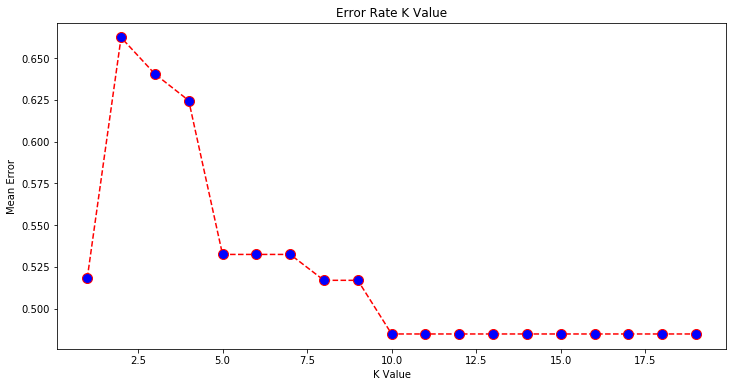

In [228]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 20), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

In [230]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.5152378428514641

In [231]:
C = result1.iloc[:, :-1].values  
D = result1.iloc[:, 2].values 


print(C)

from sklearn.model_selection import train_test_split
A_train, a_test, b_train, b_test = train_test_split(C, D, test_size=0.2, random_state=42)


[[10.  1.]
 [10.  1.]
 [18.  0.]
 ...
 [17.  0.]
 [17.  0.]
 [18.  0.]]


In [234]:

from sklearn.neighbors import KNeighborsClassifier  
#for weights in ['uniform', 'distance']:
classifier = KNeighborsClassifier(n_neighbors=13,weights=weights)  
classifier.fit(A_train, b_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='distance')

In [235]:

b_pred = classifier.predict(a_test)  

from sklearn.metrics import accuracy_score
accuracy_score(b_test, b_pred)

0.8106532396978932

In [236]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(b_test, b_pred))  
print(classification_report(b_test, b_pred))  

[[   0    2    0   28   26   49]
 [   0   16    0  127  397    0]
 [   0    0   37   53  355  207]
 [   0    1    0  479 1411    0]
 [   0    9    0  193 4112    0]
 [   0    0    0    0    0 7592]]
             precision    recall  f1-score   support

         00       0.00      0.00      0.00       105
         10       0.57      0.03      0.06       540
         11       1.00      0.06      0.11       652
         20       0.54      0.25      0.35      1891
         21       0.65      0.95      0.77      4314
         22       0.97      1.00      0.98      7592

avg / total       0.80      0.81      0.77     15094



/Users/ravs/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [237]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 20):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(A_train, b_train)
    pred_i = knn.predict(a_test)
    error.append(np.mean(pred_i != y_test))

Text(0,0.5,'Mean Error')

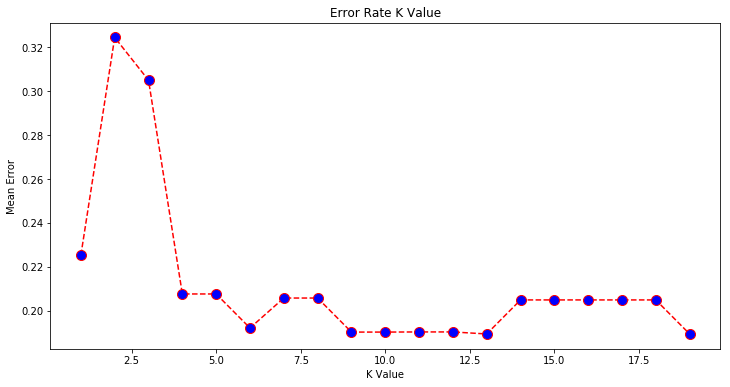

In [238]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 20), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

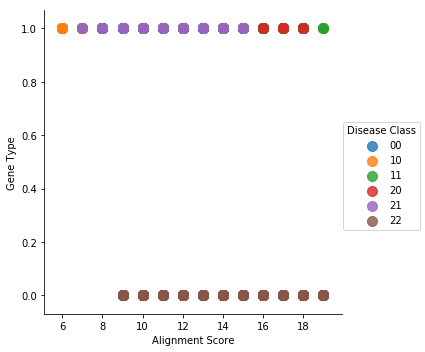

In [239]:
import seaborn

seaborn.lmplot('Alignment Score', 'Gene Type', data=result1, 
       fit_reg=False,hue="Disease Class", scatter_kws={"marker": "D","s": 100})

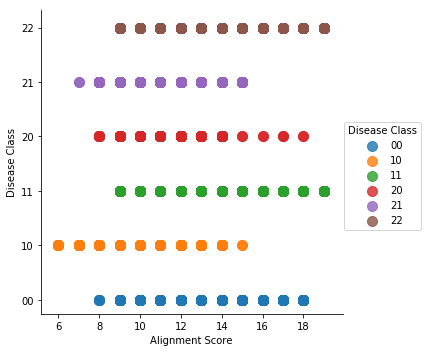

In [246]:
import seaborn

seaborn.lmplot('Alignment Score','Disease Class', data=result, 
       fit_reg=False,hue="Disease Class", scatter_kws={"marker": "D","s": 100})